In [1]:
import os
import sys

# Add the `src` directory to Python's module search path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Go up one level from `notebooks`
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

In [2]:
# Configure logging
import logging

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

from transit_opt.preprocessing.prepare_gtfs import GTFSDataPreparator

logging.basicConfig(level=logging.INFO)


## Load and Prepare GTFS Data

In [3]:
preparator = GTFSDataPreparator(
    gtfs_path='../data/external/study_area_gtfs_bus.zip',
    interval_hours=3,  # 8 periods per day
    date=None,  # Use full GTFS feed
    turnaround_buffer=1.15,  # 15% buffer
    max_round_trip_minutes= 240.0,  # Maximum round-trip time in minutes
    no_service_threshold_minutes= 480.0,  # Threshold for no-service mapping
    log_level="DEBUG"  # Use "INFO" for production, "DEBUG" for development
)

# Define allowed headways
allowed_headways = [10, 15, 30, 60, 120]
# Extract all data from the GTFS feed needed for optimization
opt_data = preparator.extract_optimization_data(allowed_headways)


2025-08-28 16:50:42,236 - transit_opt.preprocessing.prepare_gtfs - INFO - Initializing GTFSDataPreparator with 3h intervals
INFO:transit_opt.preprocessing.prepare_gtfs:Initializing GTFSDataPreparator with 3h intervals
2025-08-28 16:50:42,237 - transit_opt.preprocessing.prepare_gtfs - DEBUG - Configuration: turnaround_buffer=1.15, max_round_trip=240.0min, no_service_threshold=480.0min
DEBUG:transit_opt.preprocessing.prepare_gtfs:Configuration: turnaround_buffer=1.15, max_round_trip=240.0min, no_service_threshold=480.0min
2025-08-28 16:50:42,238 - transit_opt.preprocessing.prepare_gtfs - INFO - Loading GTFS feed from ../data/external/study_area_gtfs_bus.zip
INFO:transit_opt.preprocessing.prepare_gtfs:Loading GTFS feed from ../data/external/study_area_gtfs_bus.zip
2025-08-28 16:50:45,182 - transit_opt.preprocessing.prepare_gtfs - DEBUG - GTFS feed loaded successfully: 187 routes, 13974 trips
DEBUG:transit_opt.preprocessing.prepare_gtfs:GTFS feed loaded successfully: 187 routes, 13974 trip

### Exploration of current service patterns

In [4]:
# =============================================================================
# DATA EXPLORATION: Understanding the Optimization Data Structure
# =============================================================================

print("=== OPTIMIZATION DATA OVERVIEW ===")
print(f"Problem Type: {opt_data['problem_type']}")
print(f"Decision Matrix Shape: {opt_data['decision_matrix_shape']}")
print(f"Variable Bounds: {opt_data['variable_bounds']}")
print(f"Number of Discrete Choices: {opt_data['n_choices']}")

print("\n=== ALLOWED HEADWAYS ===")
for i, headway in enumerate(opt_data['allowed_headways']):
    if headway >= 9000:
        print(f"  Index {i}: No Service ({headway})")
    else:
        print(f"  Index {i}: {headway:.0f} minutes")

print("\n=== TIME INTERVALS ===")
for i, (label, hours) in enumerate(zip(opt_data['intervals']['labels'], opt_data['intervals']['hours'], strict=False)):
    print(f"  Interval {i}: {label} ({hours[0]:02d}:00-{hours[1]:02d}:00)")

=== OPTIMIZATION DATA OVERVIEW ===
Problem Type: discrete_headway_optimization
Decision Matrix Shape: (141, 8)
Variable Bounds: (0, 5)
Number of Discrete Choices: 6

=== ALLOWED HEADWAYS ===
  Index 0: 10 minutes
  Index 1: 15 minutes
  Index 2: 30 minutes
  Index 3: 60 minutes
  Index 4: 120 minutes
  Index 5: No Service (9999.0)

=== TIME INTERVALS ===
  Interval 0: 00-03h (00:00-03:00)
  Interval 1: 03-06h (03:00-06:00)
  Interval 2: 06-09h (06:00-09:00)
  Interval 3: 09-12h (09:00-12:00)
  Interval 4: 12-15h (12:00-15:00)
  Interval 5: 15-18h (15:00-18:00)
  Interval 6: 18-21h (18:00-21:00)
  Interval 7: 21-24h (21:00-24:00)


In [5]:
# =============================================================================
# ROUTE CHARACTERISTICS ANALYSIS
# =============================================================================

route_ids = opt_data['routes']['ids']
round_trip_times = opt_data['routes']['round_trip_times']
current_headways = opt_data['routes']['current_headways']

print("=== ROUTE CHARACTERISTICS ===")
print(f"Total Routes: {len(route_ids)}")

print("\n🚌 ROUND-TRIP TIME DISTRIBUTION:")
print(f"  Min: {np.min(round_trip_times):.1f} minutes")
print(f"  Mean: {np.mean(round_trip_times):.1f} minutes")
print(f"  Median: {np.median(round_trip_times):.1f} minutes")
print(f"  Max: {np.max(round_trip_times):.1f} minutes")

# Categorize routes by round-trip time
short_routes = np.sum(round_trip_times <= 60)
medium_routes = np.sum((round_trip_times > 60) & (round_trip_times <= 120))
long_routes = np.sum(round_trip_times > 120)

print("\n🚌 ROUTE CATEGORIES BY DURATION:")
print(f"  Short Routes (≤60min): {short_routes} ({100*short_routes/len(route_ids):.1f}%)")
print(f"  Medium Routes (60-120min): {medium_routes} ({100*medium_routes/len(route_ids):.1f}%)")
print(f"  Long Routes (>120min): {long_routes} ({100*long_routes/len(route_ids):.1f}%)")

print("\n📊 SERVICE COVERAGE BY INTERVAL:")
for i, label in enumerate(opt_data['intervals']['labels']):
    active_routes = np.sum(~np.isnan(current_headways[:, i]))
    coverage_pct = 100 * active_routes / len(route_ids)
    print(f"  {label}: {active_routes}/{len(route_ids)} routes active ({coverage_pct:.1f}%)")

=== ROUTE CHARACTERISTICS ===
Total Routes: 141

🚌 ROUND-TRIP TIME DISTRIBUTION:
  Min: 13.8 minutes
  Mean: 115.2 minutes
  Median: 110.4 minutes
  Max: 239.2 minutes

🚌 ROUTE CATEGORIES BY DURATION:
  Short Routes (≤60min): 20 (14.2%)
  Medium Routes (60-120min): 61 (43.3%)
  Long Routes (>120min): 60 (42.6%)

📊 SERVICE COVERAGE BY INTERVAL:
  00-03h: 9/141 routes active (6.4%)
  03-06h: 38/141 routes active (27.0%)
  06-09h: 106/141 routes active (75.2%)
  09-12h: 86/141 routes active (61.0%)
  12-15h: 94/141 routes active (66.7%)
  15-18h: 106/141 routes active (75.2%)
  18-21h: 74/141 routes active (52.5%)
  21-24h: 48/141 routes active (34.0%)


In [6]:
# =============================================================================
# CURRENT HEADWAY PATTERNS ANALYSIS
# =============================================================================

print("=== CURRENT HEADWAY PATTERNS ===")

# Overall statistics - Filter out extreme values using threshold
valid_headways = current_headways[~np.isnan(current_headways)]
# Filter out values above the no-service threshold (typically 480 minutes = 8 hours)
regular_service_headways = valid_headways[valid_headways < preparator.no_service_threshold_minutes]

if len(regular_service_headways) > 0:
    print(f"\n📈 HEADWAY STATISTICS (regular service only, <{preparator.no_service_threshold_minutes:.0f}min):")
    print(f"  Min: {np.min(regular_service_headways):.1f} minutes")
    print(f"  Mean: {np.mean(regular_service_headways):.1f} minutes")
    print(f"  Median: {np.median(regular_service_headways):.1f} minutes")
    print(f"  Max: {np.max(regular_service_headways):.1f} minutes")
    print(f"  Count: {len(regular_service_headways):,} intervals (vs {len(valid_headways):,} total)")

    # Headway distribution (using regular service only)
    frequent = np.sum(regular_service_headways <= 15)
    moderate = np.sum((regular_service_headways > 15) & (regular_service_headways <= 60))
    infrequent = np.sum(regular_service_headways > 60)

    print("\n📊 SERVICE FREQUENCY DISTRIBUTION (regular service):")
    print(f"  Frequent Service (≤15min): {frequent} ({100*frequent/len(regular_service_headways):.1f}%)")
    print(f"  Moderate Service (15-60min): {moderate} ({100*moderate/len(regular_service_headways):.1f}%)")
    print(f"  Infrequent Service (>60min): {infrequent} ({100*infrequent/len(regular_service_headways):.1f}%)")

    # Show extreme values separately
    extreme_headways = valid_headways[valid_headways >= preparator.no_service_threshold_minutes]
    if len(extreme_headways) > 0:
        print(f"\n⚠️  IRREGULAR SERVICE (≥{preparator.no_service_threshold_minutes:.0f}min): {len(extreme_headways)} intervals")
        print("  These represent once-daily, once-weekly, or irregular services")
        print(f"  Values: {np.unique(extreme_headways)[:5]} {'...' if len(np.unique(extreme_headways)) > 5 else ''}")

else:
    print(f"\n⚠️  No regular service found (all headways ≥{preparator.no_service_threshold_minutes:.0f}min)")

# Service patterns by time of day (also filter extreme values)
print("\n🕐 AVERAGE HEADWAYS BY TIME OF DAY (regular service only):")
for i, label in enumerate(opt_data['intervals']['labels']):
    interval_headways = current_headways[:, i]
    valid_interval = interval_headways[~np.isnan(interval_headways)]
    regular_interval = valid_interval[valid_interval < preparator.no_service_threshold_minutes]

    if len(regular_interval) > 0:
        avg_headway = np.mean(regular_interval)
        print(f"  {label}: {avg_headway:.1f} min average ({len(regular_interval)} regular routes, {len(valid_interval)-len(regular_interval)} irregular)")
    elif len(valid_interval) > 0:
        irregular_count = len(valid_interval) - len(regular_interval)
        print(f"  {label}: No regular service ({irregular_count} irregular routes)")
    else:
        print(f"  {label}: No active routes")

=== CURRENT HEADWAY PATTERNS ===

📈 HEADWAY STATISTICS (regular service only, <480min):
  Min: 1.0 minutes
  Mean: 22.2 minutes
  Median: 17.2 minutes
  Max: 125.0 minutes
  Count: 459 intervals (vs 561 total)

📊 SERVICE FREQUENCY DISTRIBUTION (regular service):
  Frequent Service (≤15min): 214 (46.6%)
  Moderate Service (15-60min): 235 (51.2%)
  Infrequent Service (>60min): 10 (2.2%)

⚠️  IRREGULAR SERVICE (≥480min): 102 intervals
  These represent once-daily, once-weekly, or irregular services
  Values: [1440.] 

🕐 AVERAGE HEADWAYS BY TIME OF DAY (regular service only):
  00-03h: 31.7 min average (6 regular routes, 3 irregular)
  03-06h: 20.3 min average (27 regular routes, 11 irregular)
  06-09h: 19.5 min average (73 regular routes, 33 irregular)
  09-12h: 25.3 min average (83 regular routes, 3 irregular)
  12-15h: 23.9 min average (85 regular routes, 9 irregular)
  15-18h: 22.0 min average (84 regular routes, 22 irregular)
  18-21h: 21.2 min average (66 regular routes, 8 irregular)

In [7]:
# =============================================================================
# INITIAL SOLUTION ANALYSIS
# =============================================================================

initial_solution = opt_data['initial_solution']
allowed_headways = opt_data['allowed_headways']

print("=== INITIAL SOLUTION MAPPING ===")
print("How current GTFS headways map to discrete choices:\n")

# Count frequency of each choice in initial solution
choice_counts = {}
for choice_idx in range(opt_data['n_choices']):
    count = np.sum(initial_solution == choice_idx)
    choice_counts[choice_idx] = count

# Display mapping statistics
total_cells = initial_solution.size
for choice_idx in sorted(choice_counts.keys()):
    count = choice_counts[choice_idx]
    percentage = 100 * count / total_cells
    headway_val = allowed_headways[choice_idx]

    if headway_val >= 9000:
        print(f"  Choice {choice_idx} (No Service): {count:,} cells ({percentage:.1f}%)")
    else:
        print(f"  Choice {choice_idx} ({headway_val:.0f}min): {count:,} cells ({percentage:.1f}%)")

service_cells = total_cells - choice_counts.get(opt_data['no_service_index'], 0)
print(f"\nOverall: {service_cells:,}/{total_cells:,} cells with active service ({100*service_cells/total_cells:.1f}%)")

=== INITIAL SOLUTION MAPPING ===
How current GTFS headways map to discrete choices:

  Choice 0 (10min): 183 cells (16.2%)
  Choice 1 (15min): 88 cells (7.8%)
  Choice 2 (30min): 134 cells (11.9%)
  Choice 3 (60min): 52 cells (4.6%)
  Choice 4 (120min): 2 cells (0.2%)
  Choice 5 (No Service): 669 cells (59.3%)

Overall: 459/1,128 cells with active service (40.7%)


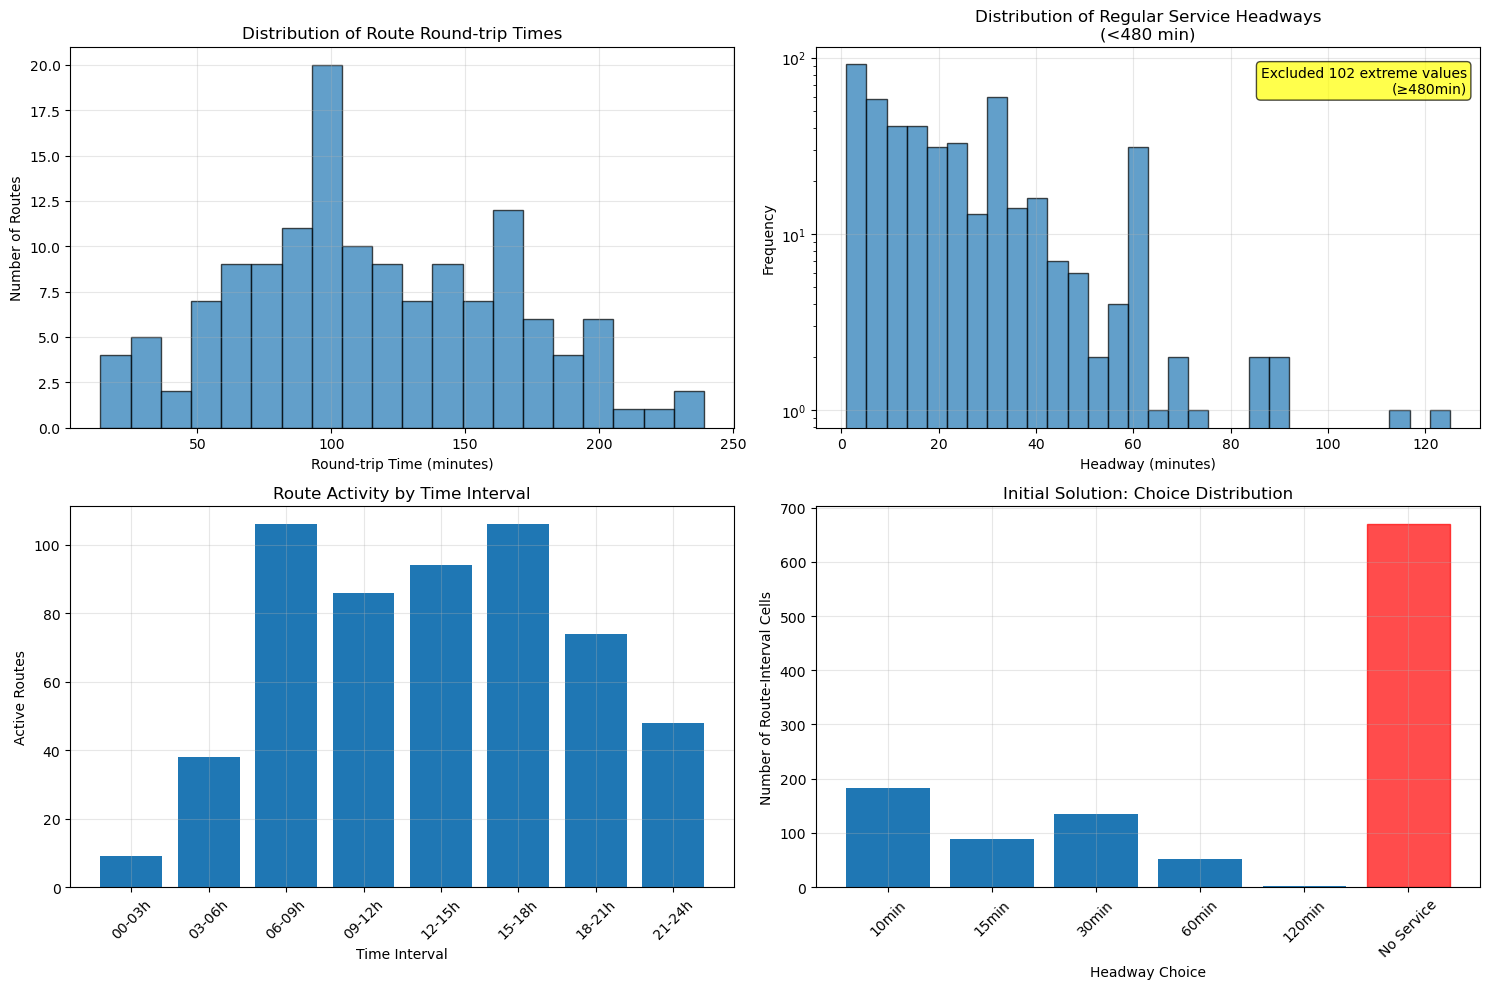


Visualization shows:
  • Route complexity (round-trip times)
  • Regular service frequency patterns (extreme values filtered)
  • When routes are most/least active
  • How existing service maps to optimization choices


In [8]:
# =============================================================================
# VISUALIZE CURRENT SERVICE PATTERNS
# =============================================================================

# Create a comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Round-trip time distribution (unchanged)
axes[0,0].hist(round_trip_times, bins=20, alpha=0.7, edgecolor='black')
axes[0,0].set_xlabel('Round-trip Time (minutes)')
axes[0,0].set_ylabel('Number of Routes')
axes[0,0].set_title('Distribution of Route Round-trip Times')
axes[0,0].grid(True, alpha=0.3)

# 2. Valid headways distribution - filter extreme values
valid_headways = current_headways[~np.isnan(current_headways)]
regular_service_headways = valid_headways[valid_headways < preparator.no_service_threshold_minutes]

if len(regular_service_headways) > 0:
    axes[0,1].hist(regular_service_headways, bins=30, alpha=0.7, edgecolor='black')
    axes[0,1].set_xlabel('Headway (minutes)')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_title(f'Distribution of Regular Service Headways\n(<{preparator.no_service_threshold_minutes:.0f} min)')
    axes[0,1].set_yscale('log')
    axes[0,1].grid(True, alpha=0.3)

    # Add text showing filtered count
    extreme_count = len(valid_headways) - len(regular_service_headways)
    axes[0,1].text(0.98, 0.95, f'Excluded {extreme_count} extreme values\n(≥{preparator.no_service_threshold_minutes:.0f}min)',
                   transform=axes[0,1].transAxes, ha='right', va='top',
                   bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
else:
    axes[0,1].text(0.5, 0.5, 'No Regular Service\nFound',
                   ha='center', va='center', transform=axes[0,1].transAxes)
    axes[0,1].set_title('Distribution of Regular Service Headways')

# 3. Service coverage by interval (unchanged)
interval_labels = opt_data['intervals']['labels']
active_counts = [np.sum(~np.isnan(current_headways[:, i])) for i in range(opt_data['n_intervals'])]

axes[1,0].bar(range(len(active_counts)), active_counts)
axes[1,0].set_xlabel('Time Interval')
axes[1,0].set_ylabel('Active Routes')
axes[1,0].set_title('Route Activity by Time Interval')
axes[1,0].set_xticks(range(len(interval_labels)))
axes[1,0].set_xticklabels(interval_labels, rotation=45)
axes[1,0].grid(True, alpha=0.3)

# 4. Initial solution choice distribution (unchanged)
choice_labels = [f"{h:.0f}min" if h < 9000 else "No Service" for h in allowed_headways]
choice_counts_list = [choice_counts.get(i, 0) for i in range(opt_data['n_choices'])]

bars = axes[1,1].bar(range(len(choice_counts_list)), choice_counts_list)
axes[1,1].set_xlabel('Headway Choice')
axes[1,1].set_ylabel('Number of Route-Interval Cells')
axes[1,1].set_title('Initial Solution: Choice Distribution')
axes[1,1].set_xticks(range(len(choice_labels)))
axes[1,1].set_xticklabels(choice_labels, rotation=45)

# Highlight no-service bar
bars[opt_data['no_service_index']].set_color('red')
bars[opt_data['no_service_index']].set_alpha(0.7)

axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nVisualization shows:")
print("  • Route complexity (round-trip times)")
print("  • Regular service frequency patterns (extreme values filtered)")
print("  • When routes are most/least active")
print("  • How existing service maps to optimization choices")

### Fleet analysis

Check the `fleet_analysis` output to see the fleet requirements of the existing service

In [9]:
# Comprehensive fleet analysis display
fleet_analysis = opt_data['constraints']['fleet_analysis']

print("=== FLEET ANALYSIS SUMMARY ===")
print(f"📊 Total Routes: {opt_data['n_routes']}")
print(f"📊 Active Routes: {fleet_analysis['fleet_stats']['routes_with_service']}")
print(f"📊 Time Intervals: {opt_data['n_intervals']} ({opt_data['intervals']['duration_minutes']//60}h each)")

print("\n🚗 FLEET REQUIREMENTS:")
print(f"Peak Fleet Needed: {fleet_analysis['total_current_fleet_peak']} vehicles")
print(f"Fleet by Interval: {fleet_analysis['current_fleet_by_interval'].tolist()}")
print(f"Peak Interval: {fleet_analysis['fleet_stats']['peak_interval']} ({opt_data['intervals']['labels'][fleet_analysis['fleet_stats']['peak_interval']]})")
print(f"Off-Peak Minimum: {fleet_analysis['fleet_stats']['off_peak_fleet']} vehicles")

print("\n📈 EFFICIENCY:")
efficiency_gain = fleet_analysis['fleet_stats']['fleet_efficiency_gain']
if efficiency_gain > 0:
    print(f"Efficiency Gain: {efficiency_gain} vehicles saved ({efficiency_gain/(fleet_analysis['total_current_fleet_peak']+efficiency_gain)*100:.1f}% reduction)")
else:
    print("No efficiency gain (all routes peak simultaneously)")

print("\n🔧 ROUTE DISTRIBUTION:")
dist = fleet_analysis['fleet_stats']['fleet_distribution']
print(f"Small Routes (1-5 vehicles): {dist['small_routes']}")
print(f"Medium Routes (6-15 vehicles): {dist['medium_routes']}")
print(f"Large Routes (>15 vehicles): {dist['large_routes']}")

print("\n⚙️ CONFIGURATION:")
print(f"Operational Buffer: {fleet_analysis['operational_buffer']} ({(fleet_analysis['operational_buffer']-1)*100:.0f}% extra time)")

=== FLEET ANALYSIS SUMMARY ===
📊 Total Routes: 141
📊 Active Routes: 110
📊 Time Intervals: 8 (3h each)

🚗 FLEET REQUIREMENTS:
Peak Fleet Needed: 1631 vehicles
Fleet by Interval: [26, 423, 1318, 1466, 1573, 1631, 1063, 657]
Peak Interval: 5 (15-18h)
Off-Peak Minimum: 26 vehicles

📈 EFFICIENCY:
Efficiency Gain: 409 vehicles saved (20.0% reduction)

🔧 ROUTE DISTRIBUTION:
Small Routes (1-5 vehicles): 41
Medium Routes (6-15 vehicles): 33
Large Routes (>15 vehicles): 36

⚙️ CONFIGURATION:
Operational Buffer: 1.15 (15% extra time)


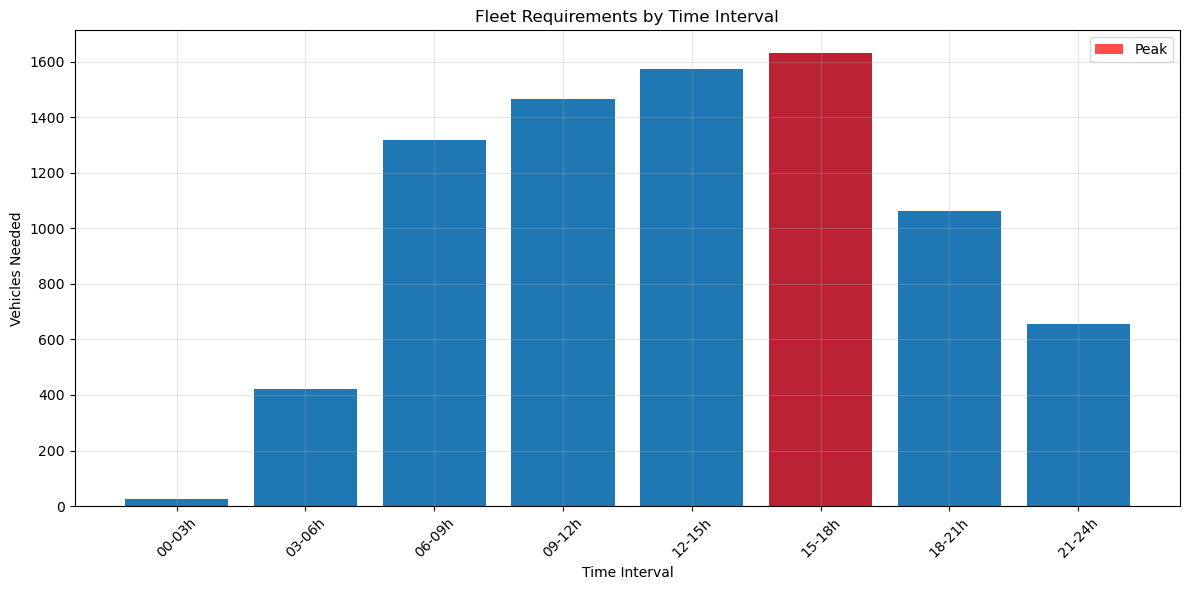

Peak occurs during 15-18h with 1631 vehicles needed


In [10]:
# Plot fleet requirements by interval
import matplotlib.pyplot as plt

fleet_by_interval = fleet_analysis['current_fleet_by_interval']
interval_labels = opt_data['intervals']['labels']

plt.figure(figsize=(12, 6))
plt.bar(range(len(fleet_by_interval)), fleet_by_interval)
plt.xlabel('Time Interval')
plt.ylabel('Vehicles Needed')
plt.title('Fleet Requirements by Time Interval')
plt.xticks(range(len(interval_labels)), interval_labels, rotation=45)
plt.grid(True, alpha=0.3)

# Highlight peak interval
peak_idx = fleet_analysis['fleet_stats']['peak_interval']
plt.bar(peak_idx, fleet_by_interval[peak_idx], color='red', alpha=0.7, label='Peak')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Peak occurs during {interval_labels[peak_idx]} with {fleet_by_interval[peak_idx]} vehicles needed")

## Objective functions

### Spatial coverage

In [ ]:
from transit_opt.optimisation.objectives import HexagonalCoverageObjective
from transit_opt.optimisation.spatial.boundaries import StudyAreaBoundary

In [ ]:
# Add this as a new cell to test boundary functionality
print("=== DEMONSTRATING BOUNDARY FUNCTIONALITY ===")

# Read in the boundary layer

boundary_gdf = gpd.read_file("../data/external/boundaries/study_area_boundary.geojson")

# Create StudyAreaBoundary
study_boundary = StudyAreaBoundary(
    boundary_gdf=boundary_gdf,
    crs="EPSG:3857",  # Convert to metric
    buffer_km=2.0     # Add 2km buffer
)

print(f"✅ Created study area boundary in {study_boundary.target_crs}")


In [ ]:
# Add this as another new cell - CORRECTED FOR EPSG:3857
if study_boundary is not None:
    print("\n=== TESTING BOUNDARY FILTERING ===")

    gtfs_feed = opt_data['reconstruction']['gtfs_feed']

    # Create stops GeoDataFrame for filtering
    stops_gdf = gpd.GeoDataFrame(
        gtfs_feed.stops,
        geometry=gpd.points_from_xy(gtfs_feed.stops.stop_lon, gtfs_feed.stops.stop_lat),
        crs="EPSG:4326"
    )

    print("📊 Original data:")
    print(f"   Total stops in GTFS: {len(stops_gdf)}")

    # Filter stops using boundary
    filtered_stops = study_boundary.filter_points(stops_gdf, output_crs="EPSG:3857")

    print("\n📊 After boundary filtering:")
    print(f"   Stops within study area: {len(filtered_stops)}")
    print(f"   Reduction: {len(stops_gdf) - len(filtered_stops)} stops ({100*(len(stops_gdf) - len(filtered_stops))/len(stops_gdf):.1f}%)")

    # Create a comparison visualization - ALL IN EPSG:3857
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Convert original stops to EPSG:3857 for consistent plotting
    stops_gdf_metric = stops_gdf.to_crs("EPSG:3857")

    # Plot 1: Original stops (converted to EPSG:3857)
    axes[0].scatter(stops_gdf_metric.geometry.x, stops_gdf_metric.geometry.y,
                   c='red', alpha=0.5, s=1)
    study_boundary.visualize(ax=axes[0], viz_crs="EPSG:3857",
                           facecolor='lightblue', alpha=0.3)
    axes[0].set_title(f'All GTFS Stops\n({len(stops_gdf):,} stops)')
    axes[0].set_xlabel('X (meters)')
    axes[0].set_ylabel('Y (meters)')

    # Plot 2: Filtered stops (already in EPSG:3857)
    axes[1].scatter(filtered_stops.geometry.x, filtered_stops.geometry.y,
                   c='green', alpha=0.7, s=1)
    study_boundary.visualize(ax=axes[1], viz_crs="EPSG:3857",
                           facecolor='lightblue', alpha=0.3)
    axes[1].set_title(f'Filtered Stops (Within Boundary)\n({len(filtered_stops):,} stops)')
    axes[1].set_xlabel('X (meters)')
    axes[1].set_ylabel('Y (meters)')

    # Set equal aspect ratio for both plots
    axes[0].set_aspect('equal')
    axes[1].set_aspect('equal')

    plt.tight_layout()
    plt.show()

    print("✅ Boundary filtering visualization created in EPSG:3857!")
    print("🗺️  All coordinates shown in meters (Web Mercator projection)")

In [ ]:
# Add this as a new cell to test the integrated system with spatial lag
if study_boundary is not None:
    print("\n=== TESTING BOUNDARY-AWARE HEXAGONAL COVERAGE OBJECTIVE WITH SPATIAL LAG ===")

    # Create objective WITHOUT boundary (for comparison)
    spatial_objective_full = HexagonalCoverageObjective(
        optimization_data=opt_data,
        spatial_resolution_km=3.0,
        crs="EPSG:3857"
    )

    # Create objective WITH boundary - STANDARD VERSION
    spatial_objective_bounded = HexagonalCoverageObjective(
        optimization_data=opt_data,
        spatial_resolution_km=3.0,
        crs="EPSG:3857",
        boundary=study_boundary,
        spatial_lag=False  # Standard variance
    )

    # Create objective WITH boundary - SPATIAL LAG VERSION
    spatial_objective_spatial = HexagonalCoverageObjective(
        optimization_data=opt_data,
        spatial_resolution_km=3.0,
        crs="EPSG:3857",
        boundary=study_boundary,
        spatial_lag=True,   # Enable spatial lag
        alpha=0.15          # 15% neighbor influence
    )

    print("\n📊 COMPARISON:")
    print("Full system:")
    print(f"   Zones: {len(spatial_objective_full.spatial_system.hex_grid)}")
    print(f"   Stops: {len(spatial_objective_full.spatial_system.stops_gdf)}")

    print("Bounded system (standard):")
    print(f"   Zones: {len(spatial_objective_bounded.spatial_system.hex_grid)}")
    print(f"   Stops: {len(spatial_objective_bounded.spatial_system.stops_gdf)}")

    print("Bounded system (spatial lag α=0.15):")
    print(f"   Zones: {len(spatial_objective_spatial.spatial_system.hex_grid)}")
    print(f"   Stops: {len(spatial_objective_spatial.spatial_system.stops_gdf)}")

    zone_reduction = len(spatial_objective_full.spatial_system.hex_grid) - len(spatial_objective_bounded.spatial_system.hex_grid)
    stop_reduction = len(spatial_objective_full.spatial_system.stops_gdf) - len(spatial_objective_bounded.spatial_system.stops_gdf)

    print("\nReduction from boundary:")
    print(f"   Zones: -{zone_reduction} ({100*zone_reduction/len(spatial_objective_full.spatial_system.hex_grid):.1f}%)")
    print(f"   Stops: -{stop_reduction} ({100*stop_reduction/len(spatial_objective_full.spatial_system.stops_gdf):.1f}%)")

    # Test evaluations - comparing standard vs spatial lag
    print("\n🎯 OBJECTIVE FUNCTION COMPARISON:")

    # Standard variance evaluation
    standard_objective = spatial_objective_bounded.evaluate(opt_data['initial_solution'])
    print(f"Standard variance objective: {standard_objective:.4f}")

    # Spatial lag variance evaluation
    spatial_objective_val = spatial_objective_spatial.evaluate(opt_data['initial_solution'])
    print(f"Spatial lag variance objective (α=0.15): {spatial_objective_val:.4f}")

    # Get detailed analyses
    standard_analysis = spatial_objective_bounded.get_detailed_analysis(opt_data['initial_solution'])
    spatial_analysis = spatial_objective_spatial.get_detailed_analysis(opt_data['initial_solution'])

    print("\n📈 DETAILED ANALYSIS COMPARISON:")
    print("Standard approach:")
    print(f"   Total vehicles (average): {standard_analysis['total_vehicles_average']}")
    print(f"   Zones with service: {standard_analysis['zones_with_service_average']}")
    print(f"   Variance: {standard_analysis['variance_average']:.4f}")
    print(f"   Coefficient of variation: {standard_analysis['coefficient_of_variation_average']:.4f}")

    print("\nSpatial lag approach (α=0.15):")
    print(f"   Total vehicles (average): {spatial_analysis['total_vehicles_average']}")
    print(f"   Zones with service: {spatial_analysis['zones_with_service_average']}")
    print(f"   Standard variance: {spatial_analysis['variance_average']:.4f}")
    print(f"   Accessibility variance: {spatial_analysis['variance_accessibility_average']:.4f}")
    print(f"   Mean accessibility: {spatial_analysis['mean_accessibility_average']:.2f}")
    print(f"   Coefficient of variation: {spatial_analysis['coefficient_of_variation_average']:.4f}")

    # Compare the effect of spatial lag
    improvement_zones = np.sum(spatial_analysis['accessibility_scores_average'] > spatial_analysis['vehicles_per_zone_average'])
    print("\n🌟 SPATIAL LAG EFFECTS:")
    print(f"   Zones with improved accessibility: {improvement_zones} out of {len(spatial_analysis['vehicles_per_zone_average'])}")
    print(f"   Accessibility boost: {spatial_analysis['mean_accessibility_average'] - spatial_analysis['mean_vehicles_average']:.2f} vehicles per zone on average")

    # Test different alpha values
    print("\n🔬 TESTING DIFFERENT ALPHA VALUES:")
    alpha_values = [0.0, 0.05, 0.1, 0.2, 0.3]

    for alpha in alpha_values:
        test_objective = HexagonalCoverageObjective(
            optimization_data=opt_data,
            spatial_resolution_km=3.0,
            crs="EPSG:3857",
            boundary=study_boundary,
            spatial_lag=(alpha > 0),
            alpha=alpha
        )

        test_value = test_objective.evaluate(opt_data['initial_solution'])
        print(f"   α = {alpha:.2f}: variance = {test_value:.4f}")

In [ ]:
if study_boundary is not None:
    print("\n=== VISUALIZING BOUNDARY-FILTERED SYSTEM WITH SPATIAL LAG COMPARISON ===")

    # Create individual plots instead of subplots
    print("📊 Full System (No Boundary):")
    spatial_objective_full.spatial_system.visualize_spatial_coverage(
        solution_matrix=opt_data['initial_solution'],
        optimization_data=opt_data,
        figsize=(12, 10),
        show_stops=True
    )
    plt.title('Full Transit System (No Boundary Filter)', fontsize=16)
    plt.show()

    print("📊 Boundary-Filtered System (Standard Variance):")
    spatial_objective_bounded.spatial_system.visualize_spatial_coverage(
        solution_matrix=opt_data['initial_solution'],
        optimization_data=opt_data,
        figsize=(12, 10),
        show_stops=True
    )
    plt.title('Boundary-Filtered Transit System (Standard Variance)', fontsize=16)
    plt.show()

    # NEW: Create accessibility visualization for spatial lag approach
    print("📊 Boundary-Filtered System with Spatial Lag Accessibility:")

    # Get the spatial lag analysis data
    spatial_analysis = spatial_objective_spatial.get_detailed_analysis(opt_data['initial_solution'])

    # Create custom visualization showing accessibility scores
    zones_with_accessibility = spatial_objective_spatial.spatial_system.hex_grid.copy()
    zones_with_accessibility['accessibility'] = spatial_analysis['accessibility_scores_average']
    zones_with_accessibility['direct_vehicles'] = spatial_analysis['vehicles_per_zone_average']

    # Convert to geographic CRS for plotting
    zones_geo = zones_with_accessibility.to_crs("EPSG:4326")
    stops_geo = spatial_objective_spatial.spatial_system.stops_gdf.to_crs("EPSG:4326")

    # Create accessibility plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))

    # Plot zones with accessibility-based coloring
    if zones_with_accessibility['accessibility'].max() > 0:
        zones_geo.plot(
            ax=ax,
            column='accessibility',
            cmap='Spectral_r',  # Different colormap to distinguish from vehicle count
            alpha=0.7,
            edgecolor='black',
            linewidth=0.5,
            legend=True,
            legend_kwds={
                'label': 'Accessibility Score (vehicles + α×neighbors)',
                'orientation': 'vertical',
                'shrink': 0.6,
                'pad': 0.1
            }
        )
    else:
        zones_geo.plot(ax=ax, color='lightgray', alpha=0.5, edgecolor='black', linewidth=0.5)

    # Add transit stops
    stops_geo.plot(
        ax=ax,
        color='blue',
        markersize=0.8,
        alpha=0.6,
        label='Transit Stops'
    )

    # Customize the plot
    ax.set_title(f'Spatial Transit Accessibility (α=0.15)\n{len(zones_geo)} zones, Mean accessibility: {spatial_analysis["mean_accessibility_average"]:.2f}',
                fontsize=14, pad=20)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)

    # Add comparison statistics text box
    comparison_stats = [
        "🔄 SPATIAL LAG COMPARISON:",
        f"Direct service variance: {spatial_analysis['variance_average']:.4f}",
        f"Accessibility variance: {spatial_analysis['variance_accessibility_average']:.4f}",
        "",
        "📈 ACCESSIBILITY BENEFITS:",
        f"Zones improved: {np.sum(spatial_analysis['accessibility_scores_average'] > spatial_analysis['vehicles_per_zone_average'])}",
        f"Mean boost: {spatial_analysis['mean_accessibility_average'] - spatial_analysis['mean_vehicles_average']:.2f}",
        f"Alpha parameter: {spatial_analysis['spatial_lag_alpha']}"
    ]

    ax.text(0.02, 0.98, "\n".join(comparison_stats), transform=ax.transAxes,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

    # Add legend for stops
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue',
               markersize=5, label='Transit Stops', alpha=0.6)
    ]
    ax.legend(handles=legend_elements, loc='upper right')

    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()

    print("✅ All three visualization approaches created!")
    print("\n💡 Benefits comparison:")
    print(f"   • Boundary filtering: {100*zone_reduction/len(spatial_objective_full.spatial_system.hex_grid):.1f}% fewer zones to process")
    print("   • Spatial lag: Accounts for neighbor accessibility effects")
    print(f"   • Accessibility scores: {spatial_analysis['mean_accessibility_average']:.2f} vs {spatial_analysis['mean_vehicles_average']:.2f} direct vehicles")
    print(f"   • Variance reduction: {((spatial_analysis['variance_average'] - spatial_analysis['variance_accessibility_average'])/spatial_analysis['variance_average']*100):+.1f}%")

In [ ]:
# Enhanced histogram showing standard vs spatial lag approaches
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Get data from both approaches
standard_analysis = spatial_objective_bounded.get_detailed_analysis(opt_data['initial_solution'])
spatial_analysis = spatial_objective_spatial.get_detailed_analysis(opt_data['initial_solution'])

vehicles_per_zone = standard_analysis['vehicles_per_zone_average']
accessibility_scores = spatial_analysis['accessibility_scores_average']

n_bins = 30  # Good balance for visualization

# Plot 1: Standard vehicle distribution
axes[0].hist(vehicles_per_zone, bins=n_bins, color='skyblue', edgecolor='black', alpha=0.7, label='Vehicle Count')
axes[0].axvline(np.mean(vehicles_per_zone), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {np.mean(vehicles_per_zone):.1f}')
axes[0].set_title('Standard Approach: Direct Vehicles per Zone')
axes[0].set_xlabel('Number of Vehicles')
axes[0].set_ylabel('Number of Zones')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Add variance text
axes[0].text(0.98, 0.95, f'Variance: {np.var(vehicles_per_zone):.4f}',
             transform=axes[0].transAxes, ha='right', va='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot 2: Spatial lag accessibility distribution
axes[1].hist(accessibility_scores, bins=n_bins, color='lightgreen', edgecolor='black', alpha=0.7, label='Accessibility Score')
axes[1].axvline(np.mean(accessibility_scores), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {np.mean(accessibility_scores):.1f}')
axes[1].set_title('Spatial Lag Approach: Accessibility Scores (α=0.15)')
axes[1].set_xlabel('Accessibility Score (vehicles + α×neighbors)')
axes[1].set_ylabel('Number of Zones')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

# Add variance text
axes[1].text(0.98, 0.95, f'Variance: {np.var(accessibility_scores):.4f}',
             transform=axes[1].transAxes, ha='right', va='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle('Distribution Comparison: Standard vs Spatial Lag Approaches', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Print comparison statistics
print("📊 DISTRIBUTION COMPARISON:")
print("Standard approach:")
print(f"   Mean: {np.mean(vehicles_per_zone):.2f}, Std: {np.std(vehicles_per_zone):.2f}, Variance: {np.var(vehicles_per_zone):.4f}")
print(f"   Range: {np.min(vehicles_per_zone):.1f} to {np.max(vehicles_per_zone):.1f}")

print("Spatial lag approach (α=0.15):")
print(f"   Mean: {np.mean(accessibility_scores):.2f}, Std: {np.std(accessibility_scores):.2f}, Variance: {np.var(accessibility_scores):.4f}")
print(f"   Range: {np.min(accessibility_scores):.1f} to {np.max(accessibility_scores):.1f}")

variance_change = ((np.var(accessibility_scores) - np.var(vehicles_per_zone)) / np.var(vehicles_per_zone)) * 100
print(f"Variance change: {variance_change:+.1f}%")

In [ ]:
def create_enhanced_faceted_histogram(spatial_objective, opt_data, figsize=(16, 14)):
    """Create faceted histograms showing both direct vehicles and accessibility by time interval."""

    vehicles_data = spatial_objective.spatial_system._vehicles_per_zone(opt_data['initial_solution'], opt_data)
    intervals_data = vehicles_data['intervals']  # Shape: (n_zones, n_intervals)
    interval_labels = vehicles_data['interval_labels']
    n_intervals = len(interval_labels)

    # Get accessibility data if spatial lag is enabled
    has_spatial_lag = hasattr(spatial_objective, 'spatial_lag') and spatial_objective.spatial_lag
    if has_spatial_lag:
        accessibility_data = np.zeros_like(intervals_data)
        for i in range(n_intervals):
            accessibility_data[:, i] = spatial_objective.spatial_system._calculate_accessibility_scores(
                intervals_data[:, i], spatial_objective.alpha
            )

    # Calculate subplot layout
    n_cols = int(np.ceil(np.sqrt(n_intervals)))
    n_rows = int(np.ceil(n_intervals / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten() if n_intervals > 1 else [axes]

    # IMPROVED: Better binning strategy
    all_values = intervals_data.flatten()
    if has_spatial_lag:
        all_values = np.concatenate([all_values, accessibility_data.flatten()])

    # Use fewer, wider bins for better readability
    max_vehicles = int(np.max(all_values))
    if max_vehicles <= 10:
        # For small ranges, use integer bins
        bins = np.arange(0, max_vehicles + 2) - 0.5
    else:
        # For larger ranges, use ~15-20 bins for better visualization
        n_bins = min(20, max_vehicles // 2 + 1)
        bins = np.linspace(-0.5, max_vehicles + 0.5, n_bins + 1)

    for i in range(n_intervals):
        ax = axes[i]
        interval_vehicles = intervals_data[:, i]

        # Plot direct vehicles with better styling
        ax.hist(interval_vehicles, bins=bins, alpha=0.7, edgecolor='black',
                color='blue', label='Direct Vehicles', linewidth=0.5)

        # Plot accessibility if available
        if has_spatial_lag:
            interval_accessibility = accessibility_data[:, i]
            ax.hist(interval_accessibility, bins=bins, alpha=0.5, edgecolor='darkred',
                    color='red', label=f'Accessibility (α={spatial_objective.alpha})', linewidth=0.5)

        # Add statistics with CLEARER LABELS
        mean_vehicles = np.mean(interval_vehicles)
        total_vehicles = np.sum(interval_vehicles)
        zones_with_service = np.sum(interval_vehicles > 0)

        # IMPROVED: More visible vertical lines with labels
        line1 = ax.axvline(mean_vehicles, color='darkblue', linestyle='--', linewidth=2, alpha=0.9,
                          label=f'Mean Direct: {mean_vehicles:.1f}')

        if has_spatial_lag:
            mean_accessibility = np.mean(interval_accessibility)
            line2 = ax.axvline(mean_accessibility, color='darkred', linestyle=':', linewidth=2, alpha=0.9,
                              label=f'Mean Access: {mean_accessibility:.1f}')

        # IMPROVED: Cleaner subplot titles
        title = f'{interval_labels[i]}'
        subtitle = f'{total_vehicles:.0f} vehicles, {zones_with_service} zones'
        if has_spatial_lag:
            subtitle += f'\nAccess boost: +{mean_accessibility - mean_vehicles:.1f}'

        ax.set_title(f'{title}\n{subtitle}', fontsize=10)
        ax.set_xlabel('Vehicles/Accessibility per Zone', fontsize=9)
        ax.set_ylabel('Number of Zones', fontsize=9)
        ax.grid(True, alpha=0.3)

        # IMPROVED: Show legend on each subplot for clarity
        ax.legend(fontsize=8, loc='upper right')

        # Better x-axis limits
        ax.set_xlim(-0.5, max_vehicles + 0.5)

        # Add text box with key stats
        stats_text = f'Max: {np.max(interval_vehicles):.0f}\nZeros: {np.sum(interval_vehicles == 0)}'
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
                verticalalignment='top', fontsize=8,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

    # Hide empty subplots
    for i in range(n_intervals, len(axes)):
        axes[i].set_visible(False)

    # IMPROVED: Better main title
    main_title = 'Vehicle Distribution by Time Interval'
    if has_spatial_lag:
        main_title += f' - Comparing Direct vs Spatial Accessibility (α={spatial_objective.alpha})'
    plt.suptitle(main_title, fontsize=14, y=0.98)

    plt.tight_layout()
    plt.show()

    # ADDED: Print summary statistics
    print("📊 SUMMARY STATISTICS:")
    for i, label in enumerate(interval_labels):
        vehicles = intervals_data[:, i]
        print(f"{label:>12}: {np.sum(vehicles):>4.0f} vehicles, {np.sum(vehicles > 0):>3} zones, mean {np.mean(vehicles):>4.1f}")

    return fig

# Use it with spatial lag objective
if study_boundary is not None:
    create_enhanced_faceted_histogram(spatial_objective_spatial, opt_data)

In [ ]:
# Get all vehicle data for zones
vehicles_data = spatial_objective_bounded.spatial_system._vehicles_per_zone(
    opt_data['initial_solution'],
    opt_data
)

print("Available data:")
print(f"- Average vehicles per zone: {vehicles_data['average'].shape}")
print(f"- Peak vehicles per zone: {vehicles_data['peak'].shape}")
print(f"- Vehicles by interval: {vehicles_data['intervals'].shape}")
print(f"- Interval labels: {vehicles_data['interval_labels']}")

# Access specific data
average_per_zone = vehicles_data['average']  # Shape: (n_zones,)
peak_per_zone = vehicles_data['peak']        # Shape: (n_zones,)
intervals_data = vehicles_data['intervals']   # Shape: (n_zones, n_intervals)

print("\nExample zone data:")
print(f"Zone 0: average={average_per_zone[0]:.1f}, peak={peak_per_zone[0]:.1f}")
print(f"Zone 0 by interval: {intervals_data[0, :]}")

In [ ]:
def create_aggregation_comparison(vehicles_data, figsize=(15, 10)):
    """Compare different aggregation methods."""

    fig, axes = plt.subplots(2, 3, figsize=figsize)

    # Data to plot
    plot_data = [
        ('Average', vehicles_data['average']),
        ('Peak', vehicles_data['peak']),
        ('Morning Peak', vehicles_data['intervals'][:, 2]),  # Assuming interval 2 is morning
        ('Afternoon Peak', vehicles_data['intervals'][:, 5]),  # Assuming interval 5 is afternoon
        ('Evening', vehicles_data['intervals'][:, 6]),  # Assuming interval 6 is evening
        ('Late Night', vehicles_data['intervals'][:, 7])   # Assuming interval 7 is late night
    ]

    axes = axes.flatten()

    for i, (title, data) in enumerate(plot_data):
        ax = axes[i]

        # Create histogram
        ax.hist(data, bins=30, alpha=0.7, edgecolor='black', color=f'C{i}')

        # Add statistics
        mean_val = np.mean(data)
        total_vehicles = np.sum(data)
        zones_with_service = np.sum(data > 0)

        ax.axvline(mean_val, color='red', linestyle='--', alpha=0.8)

        # Customize
        ax.set_title(f'{title}\nMean: {mean_val:.1f}, Total: {total_vehicles:.0f}')
        ax.set_xlabel('Vehicles per Zone')
        ax.set_ylabel('Number of Zones')
        ax.grid(True, alpha=0.3)

    plt.suptitle('Vehicle Distribution: Different Aggregation Methods', fontsize=16)
    plt.tight_layout()
    plt.show()

create_aggregation_comparison(vehicles_data)